# Network_analyser

## Imports

In [30]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')

## Network reader

### Read to pandas

In [31]:
SOURCE = ''
TARGET = ''
LINK_WEIGHT = ''
DIRECTION= ''
def set_names(source, target, link_weight, direction):
    global SOURCE
    global TARGET
    global LINK_WEIGHT
    global DIRECTION
    SOURCE = source
    TARGET = target
    LINK_WEIGHT = link_weight
    DIRECTION = direction

In [32]:
def read(file_name, sheet_name, project = True): 
    df = pd.read_excel(file_name, sheet_name = sheet_name)
    df.head()
    df = df.rename(columns={SOURCE: 'source', TARGET: 'target', LINK_WEIGHT : 'weight', DIRECTION : 'direction'})
    if project:
        return df[['source', 'target', 'weight', 'direction']]
    return df

### Convert to directed network

In [33]:
def convert(df):
    is_zero = df['direction'] == 0
    undirected_part = df[is_zero]
    undirected_part.rename(columns={'source': 'target', 'target': 'source'})
    directed = df.append(undirected_part)
    return directed[['source', 'target', 'weight']]

## Generate network

In [34]:
def generateNetwork(df):
    MDG = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr = 'weight')
    return MDG

### Filter non-connected components

In [35]:
def filterComponents(MDG):
    components = [c for c in nx.connected_components(MDG)]
    invalid_nodes = []
    for c_set in components[1:]:
        for node in c_set:
            invalid_nodes.append(node)
    for node in invalid_nodes:
        MDG.remove_node(node)
    return MDG

## Analyse tools

### Plot function

In [36]:
def plotHistogram(array, bins, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.hist(array, bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

In [37]:
def plotHistogram_below(array, bins, title, xlabel, ylabel, below):
    fig, ax = plt.subplots()
    ax.hist(array[array < below], bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

### Distribution of degrees

In [38]:
def degreeDistribution(MDG, bins = None):
    degrees = [y for x, y, in MDG.degree]
    print('Distribution of degrees:')
    plt.hist(degrees, bins)
    plotHistogram(degrees, bins, title = 'Distribution of degrees', 
                  xlabel = 'Degrees', ylabel = 'Degree values in bin')

### Betweeness centrality

#### Distribution (nodes)

In [40]:
def bcDistributionNodes(MDG, bins = None, normalize = False, below = None, weight_ = None):
    bc = nx.betweenness_centrality(MDG, normalized = normalize, weight = weight_).values()
    bc = np.fromiter(bc, dtype = float)
    print('Avarage:', np.mean(bc))
    if below == None:
        plotHistogram(bc, bins, title = 'Distribution of betweenness centrality with nodes', 
                      xlabel = 'Betweeness', ylabel = 'Number of betweenness values in bin')
    else:
        plotHistogram_below(bc, bins, title = 'Distribution of betweenness centrality with nodes', 
                      xlabel = 'Betweeness', ylabel = 'Number of betweenness values in bin', below = below)

#### Distribution (edges)

In [41]:
def bcDistributionEdges(MDG, bins = None, normalize = False, below = None, weight_ = None):
    bc = nx.edge_betweenness_centrality(MDG, normalized = normalize, weight = weight_).values()
    bc = np.fromiter(bc, dtype = float)
    print('Avarage:', np.mean(bc))
    if below == None:
        plotHistogram(bc, bins, title = 'Distribution of betweenness centrality with edges', 
                      xlabel = 'Betweeness', ylabel = 'Number of betweenness values in bin')
    else:
        plotHistogram_below(bc, bins, title = 'Distribution of betweenness centrality with nodes', 
                      xlabel = 'Betweeness', ylabel = 'Number of betweenness values in bin', below = below)

### Shortest paths

#### Avarage

In [42]:
def avarageShortestPathLength(MDG, method_ = 'bellman-ford', weight_ = None):
    print('Avarage of shortest path length:', 
          nx.average_shortest_path_length(MDG, method = method_, weight = weight_))

#### Distribution

In [43]:
def distributionShortestPaths(MDG, bins = None, weight_ = None, method_ = 'bellman-ford'):
    lengths = nx.shortest_path_length(MDG, weight = weight_, method = method_)
    path = []
    path = [c for c in lengths]
    
    length = []
    for name, l in path:
        for key in l:
            length.append(l[key])
            
    length = np.array(length)
    plotHistogram(length, bins, title = 'Distribution of shortest path lengths', 
                  xlabel = 'Length', ylabel ='Number of length values in bin')
    
    

### Diameter

In [44]:
def diameter(MDG):
     print('Diameter:', nx.diameter(MDG))

In [45]:
def diameterWeighted(MDG, weight_ , method_ = 'bellman-ford'):
    lengths = nx.shortest_path_length(MDG, weight = weight_, method = method_)
    path = []
    path = [c for c in lengths]
    
    length = []
    for name, l in path:
        for key in l:
            length.append(l[key])
            
    length = np.array(length)
    print('Weighted diameter:', np.max(length))

## Init

### Create network

In [46]:
set_names('Name_source', 'Name_target', 'Link weight (sensitive)', 'consensus_direction' )
sensitive = read('omnipath_cytoscape.xlsx', sheet_name = 'Sensitive.')

directed_s = convert(sensitive)
MDG_sensitive = nx.MultiDiGraph()
MDG_sensitive = generateNetwork(directed_s)
MDG_sensitve = filterComponents(MDG_sensitive)

In [47]:
set_names('Source', 'Target', 'link weight (healthy)', 'consensus_direction' )
normal = read('omnipath_normal_cytoscape.xlsx', sheet_name = 'network')

directed_n = convert(normal)
MDG_normal = nx.MultiDiGraph()
MDG_normal = generateNetwork(directed_n)
MDG_normal = filterComponents(MDG_normal)

### Analyse

#### Normal

Distribution of degrees:


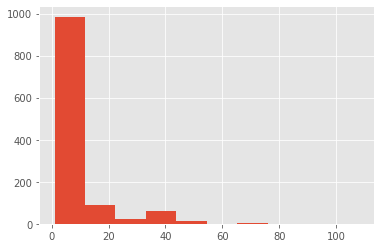

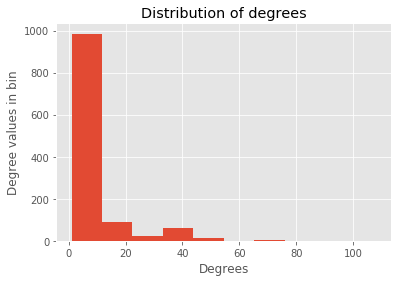

In [48]:
degreeDistribution(MDG_normal)

#### Sensitive

Distribution of degrees:


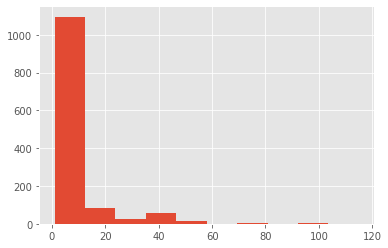

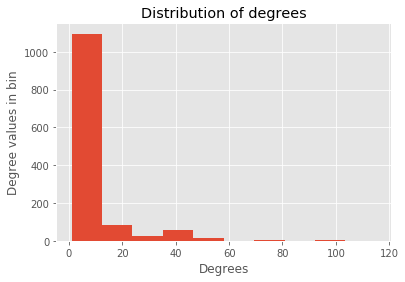

In [49]:
degreeDistribution(MDG_sensitive)

#### Normal

Avarage: 1881.303722504231


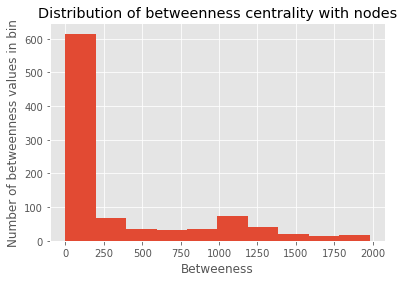

In [50]:
bcDistributionNodes(MDG_normal, below = 2000)

#### Sensitive

Avarage: 2052.580996884735


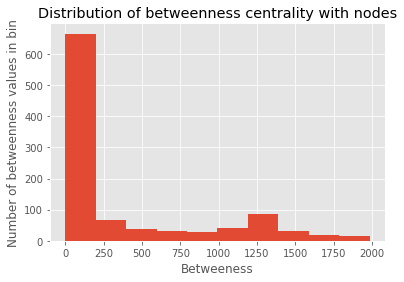

In [51]:
bcDistributionNodes(MDG_sensitive, below = 2000)

#### Normal

Avarage: 669.1873568483738


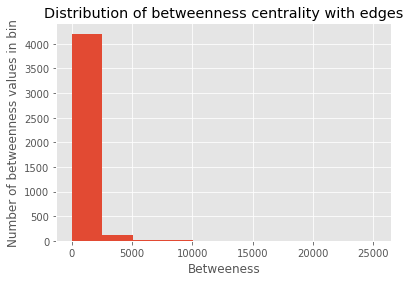

In [52]:
bcDistributionEdges(MDG_normal)

#### Sensitive

Avarage: 727.7929728592468


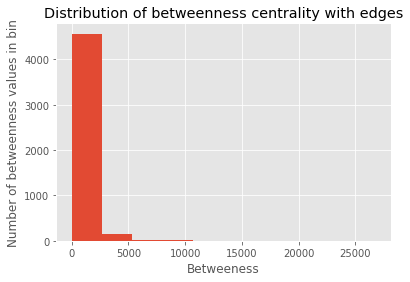

In [53]:
bcDistributionEdges(MDG_sensitive)

#### Normal

In [54]:
avarageShortestPathLength(MDG_normal)

Avarage of shortest path length: 4.185950419143489


#### Sensitive

In [55]:
avarageShortestPathLength(MDG_sensitive)

Avarage of shortest path length: 4.199658607770437


#### Normal

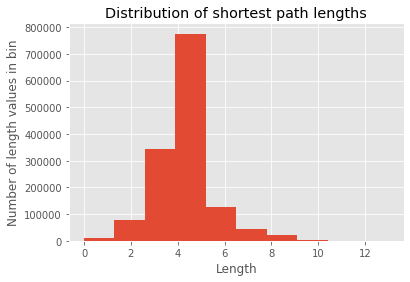

In [56]:
distributionShortestPaths(MDG_normal)

#### Sensitive

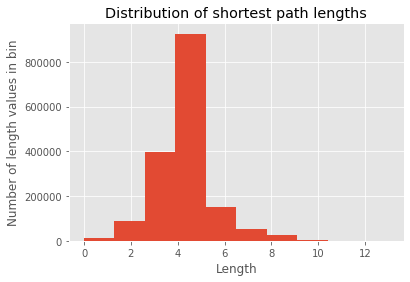

In [57]:
distributionShortestPaths(MDG_sensitive)

#### Normal

In [58]:
diameter(MDG_normal)

Diameter: 13


#### Sesitive

In [59]:
diameter(MDG_sensitive)

Diameter: 13
